# Setup

In [0]:
!git clone https://github.com/CW-Huang/IFT6135H19_assignment.git

In [0]:
%cd IFT6135H19_assignment/assignment3

In [0]:
import os

import scipy
import scipy.io

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch.optim import Adam
from torch.cuda import FloatTensor
from torchvision.utils import save_image
from torchvision import utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files

In [0]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])

In [0]:
def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [0]:
batch_size = 64

In [0]:
train, valid, test = get_data_loader("svhn", batch_size)

# GAN

The GAN generator and discriminator architectures largely follow those of https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py. In testing, we found an obvious need for some balance between the Generator and Discriminator architectures to prevent mode collapse or one dominating loss. This exposes the fragility of GANs and the need for extensive tuning. Model selection itself is some form of hyperparameter tuning.

In [0]:
'''
Generator Model inspired by
 - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
 - https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py
 - https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py
'''
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

In [0]:
'''
Discriminator Model
'''
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0)
        )


    def forward(self, x):
        return self.layers(x)

In [0]:
'''
Run GAN w/ Wasserstein form loss
'''
num_epochs = 10
critic_iterations = 5

generator = Generator().cuda()
discriminator = Discriminator().cuda()

opt_generator = Adam(generator.parameters())
opt_discriminator = Adam(discriminator.parameters())

In [0]:
'''
Helper functions for saving models and sample images.
Modified from https://github.com/Zeleni9
'''

def real_images(images, number_of_images):
    return to_np(images.view(-1, 3, 32, 32)[:number_of_images])

def generate_img(g, z, number_of_images):
    samples = g(z).data.cpu().numpy()[:number_of_images]
    generated_images = []
    for sample in samples:
        generated_images.append(sample.reshape(3, 32, 32))
    return generated_images

def to_np(x):
    return x.data.cpu().numpy()

def save_model(g, d, g_fname='./generator.pt', d_fname='./discriminator.pt'):
    print('Saving Models')
    torch.save(g.state_dict(), g_fname)
    torch.save(d.state_dict(), d_fname)

def load_model(D_model_filename, G_model_filename):
    D_model_path = os.path.join(os.getcwd(), D_model_filename)
    G_model_path = os.path.join(os.getcwd(), G_model_filename)
    discriminator.load_state_dict(torch.load(D_model_path))
    generator.load_state_dict(torch.load(G_model_path))
    print('Generator model loaded from {}.'.format(G_model_path))
    print('Discriminator model loaded from {}-'.format(D_model_path))
    
def save_samples(g, directory, fname):
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Denormalize images and save them in grid 8x8
    z = Variable(torch.randn(800, 100, 1, 1).cuda())
    samples = g(z)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.data.cpu()[:64]
    grid = utils.make_grid(samples)
    utils.save_image(grid, directory + fname)

In [0]:
fake_label = FloatTensor([1]).cuda()
real_label = FloatTensor([-1]).cuda()

for i_epoch in range(num_epochs):
    d_total_loss = 0
    g_total_loss = 0
    
    for i_batch, (images, _) in enumerate(train):
        # Skip partial batches.
        if (images.size()[0] != batch_size):
            continue
        
        discriminator.train()
        discriminator.zero_grad()

        images = Variable(images.cuda())
        real_discriminator_loss = discriminator(images).mean()
        real_discriminator_loss.backward(real_label)
        
        z = Variable(torch.randn(batch_size, 100, 1, 1).cuda())
        fake_images = generator(z)
        fake_discriminator_loss = discriminator(fake_images).mean()
        fake_discriminator_loss.backward(fake_label)

        '''
        Get the gradient penalty with lambda=10
        Modified from Problem 1 and again Zeleni9
        '''
        alpha = FloatTensor(batch_size, 1, 1, 1).uniform_(0, 1).expand(batch_size, 3, 32, 32).cuda()
        interpolated = alpha * images + ((1 - alpha) * fake_images)
        interpolated = Variable(interpolated.cuda(), requires_grad=True)
        interpolated_out = discriminator(interpolated)
        gradients = autograd.grad(outputs=interpolated_out, inputs=interpolated,
                                  grad_outputs=torch.ones(interpolated_out.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = 10 * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        gradient_penalty.backward(retain_graph=True)

        discriminator_loss = fake_discriminator_loss - real_discriminator_loss + gradient_penalty
        distance = real_discriminator_loss - fake_discriminator_loss
        opt_discriminator.step()
        
        # Continue with the for loop unless done critic_iterations number of batches
        if i_batch % critic_iterations != 0:
            continue

        discriminator.eval()
        generator.zero_grad()
        
        z = Variable(torch.randn(batch_size, 100, 1, 1).cuda())
        fake_images = generator(z)
        generator_loss = discriminator(fake_images).mean()
        generator_loss.backward(real_label)
        opt_generator.step()

        if (i_batch) % 100 == 0:
            save_model(generator, discriminator)
            save_samples(generator, 'training_result_images/gan/', '%d_%d.png' % (i_epoch, i_batch))

            losses = { 
                       'WD': distance.item(),
                       'DLoss': discriminator_loss.item(),
                       'GLoss': generator_loss.item()
                     }
            
            print("Epoch: %d; Batch: %d" % (i_epoch, i_batch), losses)

# Save the trained parameters
save_model()

# VAE

Training procedure based on pseudocode in the slides and https://github.com/pytorch/examples/blob/master/vae/main.py

In [0]:
'''
Encoder Model
Almost the exact save architecture as the discriminator except final layer has 200 output channels instead of 1.
'''
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.mean = nn.Conv2d(in_channels=1024, out_channels=100, kernel_size=4, stride=1, padding=0)
        self.logvar = nn.Conv2d(in_channels=1024, out_channels=100, kernel_size=4, stride=1, padding=0)

    def forward(self, x):
        x = self.layers(x)
        return self.mean(x), self.logvar(x)

In [0]:
num_epochs = 10

# Setup models
encoder = Encoder().cuda()
decoder = Generator().cuda()

optimizer = Adam([
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
])

In [0]:
'''
calculate elbo
'''
def vae_loss(x_given_z, x, mu, logvar):
    p_x = torch.mean((x_given_z - x) ** 2)

    KL_divergence = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) / (batch_size * (32*32*3))
    
    elbo = p_x + KL_divergence
    
    return elbo

In [0]:
for i_epoch in range(num_epochs):
    train_loss = 0
    
    for i_batch, (images, _) in enumerate(train):
        print(i_batch)
        
        images = images.cuda()
        
        optimizer.zero_grad()
        
        mu, logvar = encoder(data)
        
        '''
        For sampling z, we must use the reparam trick
        s.t. randomness is introduced by epsilon and gradients
        can flow back through mu and logvar
        '''
        standard_deviation = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(standard_deviation)
        z = mu + epsilon*std
        
        x_given_z = decoder(z)
        
        loss = vae_loss(x_given_z, images, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i_batch % 100 == 0:
            save_model(decoder, encoder, './decoder.pt', './encoder.pt')
            save_samples(decoder, 'training_result_images/vae/', '%d_%d.png' % (i_epoch, i_batch))
            
            losses = { 
                       'Loss': train_loss
                     }
            
            print("Epoch: %d; Batch: %d" % (i_epoch, i_batch), losses)

# Save results


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!cp generator.pt '/content/gdrive/My Drive/dl_a3_results/generator_final.pt'
!cp discriminator.pt '/content/gdrive/My Drive/dl_a3_results/discriminator_final.pt'

In [0]:
!cp encoder.pt '/content/gdrive/My Drive/dl_a3_results/encoder_final.pt'
!cp decoder.pt '/content/gdrive/My Drive/dl_a3_results/decoder_final.pt'

# Qualitative Evaluation

In [0]:
def save_1000_images(g, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Denormalize images and save them
    z = Variable(torch.randn(1000, 100, 1, 1).cuda())
    samples = g(z)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.data.cpu()
    for i, s in enumerate(samples):
        utils.save_image(s, directory + str(i) + '.png')

In [0]:
save_1000_images(generator, 'results/1000/gan/samples/')

In [0]:
save_1000_images(decoder, 'results/1000/vae/samples/')

Part 1. Present some visual samples

In [0]:
def print_samples(path, n=1):
    for i in range(n):
        plt.figure()
        img = mpimg.imread(path + str(i) + '.png')
        plt.imshow(img)
    plt.show()

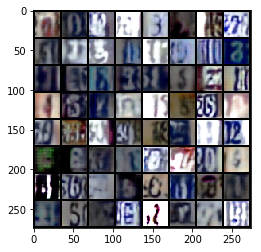

In [263]:
save_samples(generator, 'results/part1/gan/', '0.png')
print_samples('results/part1/gan/')

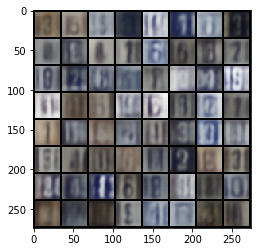

In [98]:
save_samples(decoder, 'results/part1/vae/', '0.png')
print_samples('results/part1/vae/')

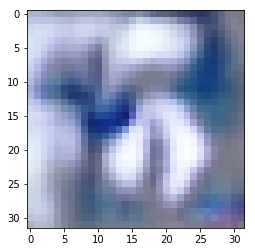

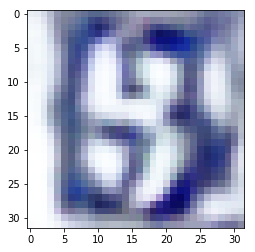

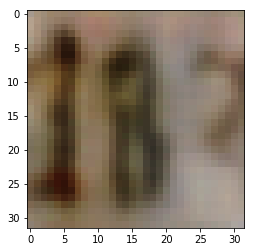

In [265]:
print_samples('results/1000/gan/samples/', n=3)

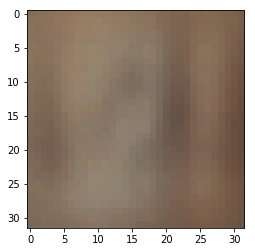

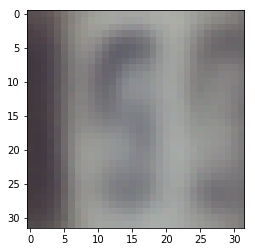

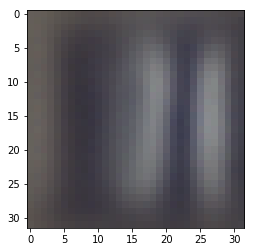

In [104]:
print_samples('results/1000/vae/samples/', n=3)

Part 2. Disentangled representation

In [0]:
def save_perturbed_samples(g, directory, fname, eps=0, z=torch.randn(100, 1, 1)):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    z = z.repeat(101, 1, 1, 1)
    
    for i in range(100):
        z[i+1, i, 0, 0] += eps
        
    z = Variable(z.cuda())
    
    samples = g(z)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.data.cpu()[:64]
    grid = utils.make_grid(samples)
    utils.save_image(grid, directory + fname)

In [0]:
def save_perturbed_samples2(g, directory, fname, eps=0):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    z1 = torch.randn(100, 1, 1)
    
    z = torch.zeros(101, 100, 1, 1)
    
    for i in range(101):
        z[i] = z1.clone()
    
    for i in range(100):
        z[i+1, i, 0, 0] += eps
        
    z = Variable(z.cuda())
    
    samples = g(z)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.data.cpu()[:64]
    grid = utils.make_grid(samples)
    utils.save_image(grid, directory + fname)

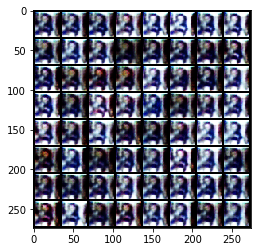

In [254]:
save_perturbed_samples(generator, 'results/part2/gan/', '0.png', eps=1, z=torch.randn(100, 1, 1))
print_samples('results/part2/gan/')

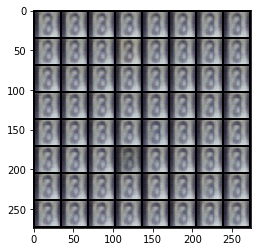

In [200]:
save_perturbed_samples(decoder, 'results/part2/vae/', '0.png')
print_samples('results/part2/vae/')

Part 3. Interpolation

In [0]:
alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def save_interpolated_samples(g, directory, z1=torch.randn(100, 1, 1), z2=torch.randn(100, 1, 1)):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    z = torch.zeros(len(alphas), 100, 1, 1)
    
    for i, alpha in enumerate(alphas):
        z[i] = alpha * z1 + (1 - alpha) * z2
        
    z = Variable(z.cuda())
    
    generated = g(z)
    
    samples = generated.mul(0.5).add(0.5)
    samples = samples.data.cpu()
    grid = utils.make_grid(samples, nrow=11)
    utils.save_image(grid, directory + '0.png')
    
    for i in range(1, len(alphas) - 1):
        alpha = alphas[i]
        generated[i] = alpha * generated[-1] + (1 - alpha) * generated[0]
        
    samples = generated.mul(0.5).add(0.5)
    samples = samples.data.cpu()
    grid = utils.make_grid(samples, nrow=11)
    utils.save_image(grid, directory + '1.png')

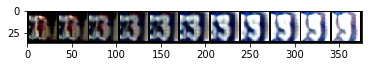

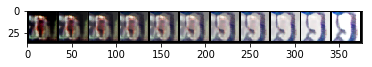

In [336]:
save_interpolated_samples(generator, 'results/part3/gan/')
print_samples('results/part3/gan/', n=2)

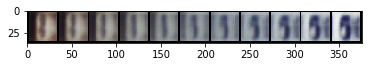

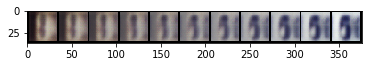

In [335]:
save_interpolated_samples(decoder, 'results/part3/vae/', z1=torch.randn(100, 1, 1), z2=torch.randn(100, 1, 1))
print_samples('results/part3/vae/', n=2)

# Quantitative Evaluation

Template code from score_fid.py

In [0]:
import argparse
import os
import torchvision
import torchvision.transforms as transforms
import torch
import classify_svhn
from classify_svhn import Classifier

SVHN_PATH = "svhn"
PROCESS_BATCH_SIZE = 32


def get_sample_loader(path, batch_size):
    """
    Loads data from `[path]/samples`
    - Ensure that path contains only one directory
      (This is due ot how the ImageFolder dataset loader
       works)
    - Ensure that ALL of your images are 32 x 32.
      The transform in this function will rescale it to
      32 x 32 if this is not the case.
    Returns an iterator over the tensors of the images
    of dimension (batch_size, 3, 32, 32)
    """
    data = torchvision.datasets.ImageFolder(
        path,
        transform=transforms.Compose([
            transforms.Resize((32, 32), interpolation=2),
            classify_svhn.image_transform
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        num_workers=2,
    )
    return data_loader


def get_test_loader(batch_size):
    """
    Downloads (if it doesn't already exist) SVHN test into
    [pwd]/svhn.
    Returns an iterator over the tensors of the images
    of dimension (batch_size, 3, 32, 32)
    """
    testset = torchvision.datasets.SVHN(
        SVHN_PATH, split='test',
        download=True,
        transform=classify_svhn.image_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
    )
    return testloader


def extract_features(classifier, data_loader):
    """
    Iterator of features for each image.
    """
    with torch.no_grad():
        for x, _ in data_loader:
            h = classifier.extract_features(x).numpy()
            for i in range(h.shape[0]):
                yield h[i]

Fid score implementation

In [0]:
from scipy import linalg
from sklearn.metrics import mean_squared_error

def calculate_fid(mu1, sigma1, mu2, sigma2):
    mse = mean_squared_error(mu1, mu2)
    fid = mse + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(linalg.sqrtm(sigma1.dot(sigma2)))
    return fid.real

def features_to_mean_var(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def calculate_fid_score(sample_feature_iterator,
                        testset_feature_iterator):
    sample_features = []
    for sf in sample_feature_iterator:
        sample_features.append(sf)
    mu1, sigma1 = features_to_mean_var(sample_features)
    
    testset_features = []
    for tsf in testset_feature_iterator:
        testset_features.append(tsf)
    mu2, sigma2 = features_to_mean_var(testset_features)
    
    return calculate_fid(mu1, sigma1, mu2, sigma2)

Print the results

In [0]:
def print_fid_score(directory, model='svhn_classifier.pt'):
    classifier = torch.load(model, map_location='cpu')
    classifier.eval()

    sample_loader = get_sample_loader(directory,
                                      PROCESS_BATCH_SIZE)
    sample_f = extract_features(classifier, sample_loader)

    test_loader = get_test_loader(PROCESS_BATCH_SIZE)
    test_f = extract_features(classifier, test_loader)

    fid_score = calculate_fid_score(sample_f, test_f)
    print("FID score:", fid_score)

In [371]:
print_fid_score('results/1000/gan/')

Using downloaded and verified file: svhn/test_32x32.mat
FID score: 8770.372867499478


In [372]:
print_fid_score('results/1000/vae/')

Using downloaded and verified file: svhn/test_32x32.mat
FID score: 34331.93547546299
